In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
os.chdir(r"/content/drive/MyDrive/CV") 
print("Directory changed") 

Directory changed


In [ ]:
!pip install opendatasets --upgrade -q


In [ ]:
import os #interact with os - python standard utility module
import torch #PyTorch for Tensor Computation like Numpy with strong GPU acceleration & to build deep neural networks with autograd system
import torchvision #consists of popular dataset, architectures and image transformations
import tarfile #reads and writes gzip , bz2 and lzma compressed archives if the respective modules are available
import torch.nn as nn #basic building block for graphs - convolutions
import numpy as np #vectors and arrays
import torch.nn.functional as F #for activation functions and convolution operations 
from torchvision.datasets import ImageFolder #datasets
from torchvision.datasets.utils import download_url #to download dataset
from torch.utils.data import DataLoader #load your own image of dataset
from torch.utils.data import random_split #to split dataset into non-overlapping datasets
import torchvision.transforms as tt #image transformations
from torchvision.utils import make_grid #displaying images
import torchvision.models as models #for initializing pretrained models
import matplotlib.pyplot as plt #graphs
import opendatasets as od  #for downloading datasets from online sources
%matplotlib inline

In [ ]:
 dataset_url = 'https://www.kaggle.com/minbavel/cifar-100-images' #url of dataset
od.download(dataset_url) #download dataset

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: srishtis1258
Your Kaggle Key: ··········
cifar-100-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#directory creation
data_dir = './cifar-100-images/CIFAR100' 
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/TRAIN")
print(classes[:10])
print(len(classes))

['TEST', 'TRAIN']
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']
100


In [ ]:
#listing name of objects with number of training images each in form of dictionary
di={}
for i in classes:
    di[i]=len(os.listdir(data_dir+"/TRAIN/"+i))
print(di)

{'apple': 500, 'aquarium_fish': 500, 'baby': 500, 'bear': 500, 'beaver': 500, 'bed': 500, 'bee': 500, 'beetle': 500, 'bicycle': 500, 'bottle': 500, 'bowl': 500, 'boy': 500, 'bridge': 500, 'bus': 500, 'butterfly': 500, 'camel': 500, 'can': 500, 'castle': 500, 'caterpillar': 500, 'cattle': 500, 'chair': 500, 'chimpanzee': 500, 'clock': 500, 'cloud': 500, 'cockroach': 500, 'couch': 500, 'crab': 500, 'crocodile': 500, 'cup': 500, 'dinosaur': 500, 'dolphin': 500, 'elephant': 500, 'flatfish': 500, 'forest': 500, 'fox': 500, 'girl': 500, 'hamster': 500, 'house': 500, 'kangaroo': 500, 'keyboard': 500, 'lamp': 500, 'lawn_mower': 500, 'leopard': 500, 'lion': 500, 'lizard': 500, 'lobster': 500, 'man': 500, 'maple_tree': 500, 'motorcycle': 500, 'mountain': 500, 'mouse': 500, 'mushroom': 500, 'oak_tree': 500, 'orange': 500, 'orchid': 500, 'otter': 500, 'palm_tree': 500, 'pear': 500, 'pickup_truck': 500, 'pine_tree': 500, 'plain': 500, 'plate': 500, 'poppy': 500, 'porcupine': 500, 'possum': 500, 'ra

In [ ]:
#Transformation of images - normalization and augmentation of images
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transformed = tt.Compose([tt.RandomCrop(32, padding=4,padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)
                        ])
valid_transformed = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)
                        ])


In [ ]:
# PyTorch datasets
train_dataset = ImageFolder(data_dir+'/TRAIN', train_transformed)
valid_dataset = ImageFolder(data_dir+'/TEST', valid_transformed)

In [ ]:
#hyperparameter defining how many samples to work with before updating the internal model parameters
batch_size = 400

In [ ]:
#Loading Training and Testing dataset
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#to show grid of images in a batch
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [ ]:
#code for selection of the device type - CPU/GPU subject to availability
def get_default_device():

   #GPU selected if available
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device): #to move tensor to the selected device type
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(): #dataloader wrapped to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self): #to yeild a batch full data after moving data to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self): #number of batches
        return len(self.dl)

In [ ]:
#check device type
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Transfering data to the device currently in use
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
#CNN architecture
def accuracy(outputs, labels): #accuracy calculation of model
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # generation of predictions
        loss = F.cross_entropy(out, labels) # loss calculation
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # generation of predictions
        loss = F.cross_entropy(out, labels)   # loss calculation
        acc = accuracy(out, labels)           # accuracy calculation
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
def conv_block(in_channels, out_channels, pool=False): #kernel size=3, padding=1 pixel, activation function used = ReLU, 5 Convolution Layers
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2)) #maxPool layer used size = 2
    return nn.Sequential(*layers)

class ResNet152(ImageClassificationBase): #5 Convolution Layers, 3 ResNet Layers for Ensemble Learning 
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) 
        self.conv2 = conv_block(64, 128, pool=True) 
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) 
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True) 
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) 
        self.conv5 = conv_block(512, 1028, pool=True)
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Linear(1028, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet152(3, 100), device)
model

ResNet152(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=

In [ ]:
#Training the model
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.010288461111485958, 'val_loss': 4.6053032875061035}]

In [ ]:
#parameter value assignment
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay =1e-4
opt_func = torch.optim.Adam

In [ ]:
#hyperparameter tuning
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00278, train_loss: 3.6969, val_loss: 3.7528, val_acc: 0.1921
Epoch [1], last_lr: 0.00759, train_loss: 2.9860, val_loss: 3.5824, val_acc: 0.2231
Epoch [2], last_lr: 0.01000, train_loss: 2.3467, val_loss: 4.1010, val_acc: 0.2930
Epoch [3], last_lr: 0.00950, train_loss: 1.9323, val_loss: 2.2102, val_acc: 0.4252
Epoch [4], last_lr: 0.00812, train_loss: 1.6634, val_loss: 2.4918, val_acc: 0.4396
Epoch [5], last_lr: 0.00611, train_loss: 1.4444, val_loss: 1.8435, val_acc: 0.5171
Epoch [6], last_lr: 0.00389, train_loss: 1.1989, val_loss: 1.5497, val_acc: 0.5807
Epoch [7], last_lr: 0.00188, train_loss: 0.9418, val_loss: 1.1895, val_acc: 0.6648
Epoch [8], last_lr: 0.00050, train_loss: 0.6855, val_loss: 1.0288, val_acc: 0.7045
Epoch [9], last_lr: 0.00000, train_loss: 0.5148, val_loss: 0.9989, val_acc: 0.7153
CPU times: user 3min 40s, sys: 3min 20s, total: 7min 1s
Wall time: 1h 17min 12s


In [ ]:
#hyperparameter tuning
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00028, train_loss: 0.4895, val_loss: 1.0081, val_acc: 0.7116
Epoch [1], last_lr: 0.00076, train_loss: 0.4973, val_loss: 1.1219, val_acc: 0.6865
Epoch [2], last_lr: 0.00100, train_loss: 0.5351, val_loss: 1.1989, val_acc: 0.6738
Epoch [3], last_lr: 0.00095, train_loss: 0.4961, val_loss: 1.1754, val_acc: 0.6760
Epoch [4], last_lr: 0.00081, train_loss: 0.4213, val_loss: 1.1799, val_acc: 0.6850
Epoch [5], last_lr: 0.00061, train_loss: 0.3235, val_loss: 1.0988, val_acc: 0.7056
Epoch [6], last_lr: 0.00039, train_loss: 0.2324, val_loss: 1.0664, val_acc: 0.7162
Epoch [7], last_lr: 0.00019, train_loss: 0.1638, val_loss: 1.0367, val_acc: 0.7289
Epoch [8], last_lr: 0.00005, train_loss: 0.1238, val_loss: 1.0322, val_acc: 0.7311
Epoch [9], last_lr: 0.00000, train_loss: 0.1073, val_loss: 1.0311, val_acc: 0.7310
CPU times: user 3min 54s, sys: 3min 34s, total: 7min 28s
Wall time: 13min 42s


In [ ]:
#hyperparameter tuning
%%time
history += fit_one_cycle(4, 0.00001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00001, train_loss: 0.1076, val_loss: 1.0287, val_acc: 0.7321
Epoch [1], last_lr: 0.00001, train_loss: 0.1043, val_loss: 1.0264, val_acc: 0.7328
Epoch [2], last_lr: 0.00000, train_loss: 0.1038, val_loss: 1.0281, val_acc: 0.7328
Epoch [3], last_lr: 0.00000, train_loss: 0.1028, val_loss: 1.0278, val_acc: 0.7335
CPU times: user 1min 29s, sys: 1min 20s, total: 2min 50s
Wall time: 5min 30s


In [ ]:
#hyperparameter tuning
%%time
history += fit_one_cycle(4, 0.0001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00009, train_loss: 0.1031, val_loss: 1.0365, val_acc: 0.7298
Epoch [1], last_lr: 0.00008, train_loss: 0.1022, val_loss: 1.0491, val_acc: 0.7288
Epoch [2], last_lr: 0.00003, train_loss: 0.0897, val_loss: 1.0521, val_acc: 0.7313
Epoch [3], last_lr: 0.00000, train_loss: 0.0825, val_loss: 1.0474, val_acc: 0.7337
CPU times: user 1min 30s, sys: 1min 20s, total: 2min 50s
Wall time: 5min 30s


In [ ]:
#hyperparameter tuning
%%time
history += fit_one_cycle(10, 0.0001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00003, train_loss: 0.0819, val_loss: 1.0490, val_acc: 0.7319
Epoch [1], last_lr: 0.00008, train_loss: 0.0815, val_loss: 1.0588, val_acc: 0.7293
Epoch [2], last_lr: 0.00010, train_loss: 0.0796, val_loss: 1.0631, val_acc: 0.7325
Epoch [3], last_lr: 0.00010, train_loss: 0.0742, val_loss: 1.0752, val_acc: 0.7294
Epoch [4], last_lr: 0.00008, train_loss: 0.0671, val_loss: 1.0801, val_acc: 0.7311
Epoch [5], last_lr: 0.00006, train_loss: 0.0601, val_loss: 1.0802, val_acc: 0.7319
Epoch [6], last_lr: 0.00004, train_loss: 0.0543, val_loss: 1.0824, val_acc: 0.7340
Epoch [7], last_lr: 0.00002, train_loss: 0.0512, val_loss: 1.0790, val_acc: 0.7353
Epoch [8], last_lr: 0.00000, train_loss: 0.0477, val_loss: 1.0804, val_acc: 0.7350
Epoch [9], last_lr: 0.00000, train_loss: 0.0465, val_loss: 1.0816, val_acc: 0.7355
CPU times: user 3min 43s, sys: 3min 23s, total: 7min 7s
Wall time: 13min 45s


In [ ]:
train_time='30:00'

In [ ]:
# Accuracy Graph
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x', color="green")
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.title('Graph of Accuracy compared to Epochs');

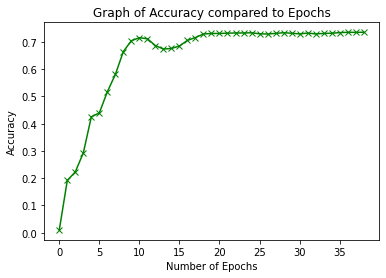

In [ ]:
plot_accuracies(history)

In [ ]:
# Training and Validation loss graph
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx', color="yellow")
    plt.plot(val_losses, '-rx', color="orange")
    plt.xlabel('no of epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss compared to Epochs');

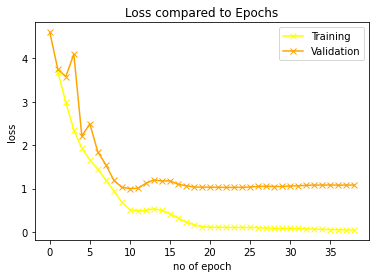

In [ ]:
plot_losses(history)

In [ ]:
# Learning Rate Graph
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs, color="pink")
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

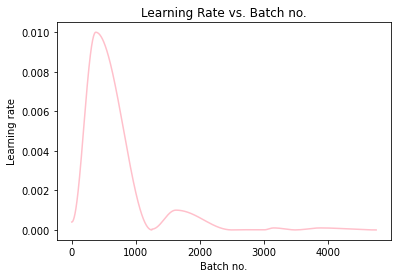

In [ ]:
plot_lrs(history)

In [ ]:
from torchvision.transforms import ToTensor
test_transformed = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)
                        ])
test_dataset = ImageFolder(data_dir+'/TEST', test_transformed)

In [ ]:
dataset = ImageFolder(data_dir+'/TRAIN', transform=ToTensor())

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: apple , Predicted: pear


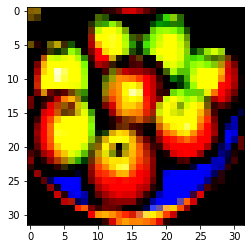

In [ ]:
#testcase
img, label = test_dataset[5]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: aquarium_fish , Predicted: aquarium_fish


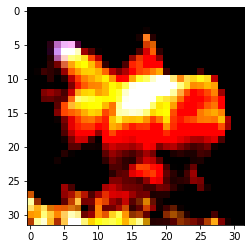

In [ ]:
#testcase
img, label = test_dataset[111]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: baby , Predicted: bed


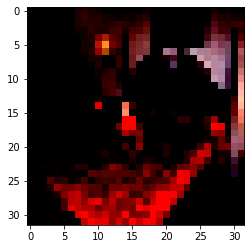

In [ ]:
#testcase
img, label = test_dataset[232]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
#testcase
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.7354808449745178, 'val_loss': 1.081560730934143}